## 주택가격 예측

In [1]:
import tensorflow as tf

In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.1.5'

 ## 데이터셋 로드하기

In [3]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

In [4]:
train_data.shape

(404, 13)

In [5]:
test_data.shape

(102, 13)

404개 훈련 102개 테스트 샘플
핏쳐 : 13
핏처 종류
 1. Per capita crime rate.
 2. Proportion of residential land zoned for lots over 25,000 square feet.
 3. Proportion of non-retail business acres per town.
 4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
 5. Nitric oxides concentration (parts per 10 million).
 6. Average number of rooms per dwelling.
 7. Proportion of owner-occupied units built prior to 1940.
 8. Weighted distances to five Boston employment centres.
 9. Index of accessibility to radial highways.  
 10. Full-value property-tax rate per $10,000.  
 11. Pupil-teacher ratio by town.  
 12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.  
 13. % lower status of the population.  


## 데이터 준비하기

 피쳐마다 스케일이 다를 경우 신경망이 학습시 문제가 됨.   
 피쳐의 정규화가 필요하다.  
  
 정규화 공식:  
 Z = X-mean / std  
 

In [6]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

## 모델 구성

예측이므로 마지막 네트워크는 선형으로 자유롭게 학습될 수 있도록 함.

In [7]:
from keras import models
from keras import layers

# 동일한 모델을 여러 번 생성할 것이므로 함수를 만들어 사용합니다
def build_model():    
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

## K-fold 검증  

데이터를 k개로 분할하여 k번 만큼 훈련과 검증데이터를 구성하여 평가하는 방법.  
검증은 k개의 평균으로 평가함.  

In [8]:
!nvidia-smi

Sat Jan 19 23:59:51 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.69                 Driver Version: 384.69                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 980 Ti  Off  | 00000000:01:00.0 Off |                  N/A |
| 20%   46C    P0    65W / 260W |      0MiB /  6077MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 980 Ti  Off  | 00000000:02:00.0 Off |                  N/A |
| 20%   43C    P0    52W / 260W |      0MiB /  6078MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [11]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('Fold : ', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    print('model_build')
    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # 검증 세트로 모델 평가
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Fold :  0
model_build
Fold :  1
model_build
Fold :  2
model_build
Fold :  3
model_build


GPU 장비 관련 이슈가 있어 글로만 학습

---2019.1.20 이슈 해결 재학습

In [12]:
all_scores

[2.0382397670557, 2.4960290866323036, 2.389962579944346, 2.457786221315365]

In [13]:
np.mean(all_scores)

2.3455044137369288

검증 세트가 다르므로 확실히 검증 점수가 2.0에서 2.8까지 변화가 큽니다. 평균값(2.4)이 각각의 점수보다 훨씬 신뢰할 만한 점수입니다. 이것이 K-겹 교차 검증의 핵심입니다. 이 예에서는 평균적으로 3,000달러 정도 차이가 납니다. 주택 가격의 범위가 10,000달러에서 50,000달러 사이인 것을 감안하면 비교적 큰 값입니다.

신경망을 조금 더 오래 500 에포크 동안 훈련해 보죠. 각 에포크마다 모델이 얼마나 개선되는지 기록하기 위해 훈련 루프를 조금 수정해서 에포크의 검증 점수를 로그에 저장하겠습니다:

In [14]:
from keras import backend as K

# 메모리 해제
K.clear_session()

In [15]:
um_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


그다음 MAE 점수 평균을 계산

In [16]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

## 그래프 그리기

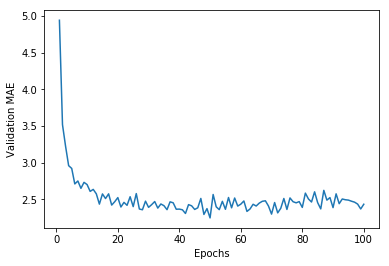

In [18]:
import matplotlib.pyplot as plt


plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()



 그래프가 보기힘든.. 다른걸보도록하자

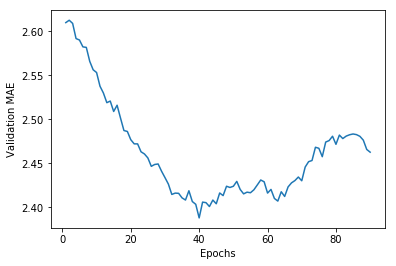

In [19]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

80번째 애폭 이후 줄어드는것을 멈춤.

회귀는 분류에서 사용했던 것과는 다른 손실 함수를 사용.  
평균 제곱 오차(MSE)는 회귀에서 자주 사용되는 손실 함수.  
비슷하게 회귀에서 사용되는 평가 지표는 분류와 다름.

당연히 정확도 개념은 회귀에 적용되지 않음.  

- 일반적인 회귀 지표는 평균 절대 오차(MAE)  
- 입력 데이터의 특성이 서로 다른 범위를 가지면 전처리 단계에서 각 특성을 개별적으로 스케일 조정해야 한다.  
- 가용한 데이터가 적다면 **K-Fold 검증**을 사용하는 것이 신뢰할 수 있는 모델 신뢰있게 평가 방법.  
- 가용한 훈련 데이터가 적다면 과대적합을 피하기 위해 은닉층의 수를 줄인 모델이 좋음(일반적으로 하나 또는 두 개)    

이과정을 마치며..
 - 이진 분류  
 - 단일 레이블 다중 분류  
 - 스칼라 회귀  